# Fairness in Machine Learning

where we discuss some techniques to assess Fairness and Mitigate bias in Machine Learning algorithms

### packages import

In [1]:
import pandas as pd
import numpy as np
# plotting
import matplotlib.pyplot as plt
import seaborn as sns
# sklearn model (logistic), utils and metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    balanced_accuracy_score,
    roc_auc_score,
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    plot_roc_curve)

### downlaod German credit dataset from UCI (University of California at Irvine) https://archive.ics.uci.edu/

In [2]:
filepath = r'https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data'
# data file is a space separated table, and has no column names, 
# so we need to attach them "by hand" looking at metadata
df = pd.read_csv(filepath, sep='\s', header=None)
df.columns = ['existingchecking', 'duration', 'credithistory', 'purpose', 
              'creditamount', 'savings', 'employmentsince', 'installmentrate', 
              'statussex', 'otherdebtors', 'residencesince', 'property', 'age',
              'otherinstallmentplans', 'housing', 'existingcredits', 'job', 
              'peopleliable', 'telephone' , 'foreignworker', 
              'classification']

print(f"German credit dataset. Number of observations: {df.shape[0]}; number of columns: {df.shape[1]}.")
df.head()

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


German credit dataset. Number of observations: 1000; number of columns: 21.


,existingchecking,duration,credithistory,purpose,creditamount,savings,employmentsince,installmentrate,statussex,otherdebtors,...,property,age,otherinstallmentplans,housing,existingcredits,job,peopleliable,telephone,foreignworker,classification
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


prepare dataset for the classification task

In [4]:
#create quickaccess list with categorical variables labels
catvars = ['existingchecking', 'credithistory', 'purpose', 'savings', 'employmentsince',
            'statussex', 'otherdebtors', 'property', 'otherinstallmentplans', 'housing', 'job',
            'telephone', 'foreignworker']
#create quickaccess list with numerical variables labels
numvars = ['creditamount', 'duration', 'installmentrate', 'residencesince', 'age',
            'existingcredits', 'peopleliable', 'classification']

# Binarize the target 0 = 'bad' credit; 1 = 'good' credit
df.classification.replace([1,2], [1,0], inplace=True)


# For simplicity we encode categories with ordinal numbers
# DON'T DO THIS AT HOME!!
for c in catvars:
    df[c] = df[c].astype("category").cat.codes

#  create gender variable deriving it from the statussex one
# -> 1= female 0 = male
df.loc[df["statussex"] == 0, "gender"] = 0
df.loc[df["statussex"] == 1, "gender"] = 1
df.loc[df["statussex"] == 2, "gender"] = 0
df.loc[df["statussex"] == 3, "gender"] = 0
df.loc[df["statussex"] == 4, "gender"] = 1

# transform all features into floats, also categorical
df = df.astype("float64")
df["classification"] = df["classification"].astype("int32")

# show a snippet of data
df.head()

,existingchecking,duration,credithistory,purpose,creditamount,savings,employmentsince,installmentrate,statussex,otherdebtors,...,age,otherinstallmentplans,housing,existingcredits,job,peopleliable,telephone,foreignworker,classification,gender
0,0.0,6.0,4.0,4.0,1169.0,4.0,4.0,4.0,2.0,0.0,...,67.0,2.0,1.0,2.0,2.0,1.0,1.0,0.0,1,0.0
1,1.0,48.0,2.0,4.0,5951.0,0.0,2.0,2.0,1.0,0.0,...,22.0,2.0,1.0,1.0,2.0,1.0,0.0,0.0,0,1.0
2,3.0,12.0,4.0,7.0,2096.0,0.0,3.0,2.0,2.0,0.0,...,49.0,2.0,1.0,1.0,1.0,2.0,0.0,0.0,1,0.0
3,0.0,42.0,2.0,3.0,7882.0,0.0,3.0,2.0,2.0,2.0,...,45.0,2.0,2.0,1.0,2.0,2.0,0.0,0.0,1,0.0
4,0.0,24.0,3.0,0.0,4870.0,0.0,2.0,3.0,2.0,0.0,...,53.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,0,0.0


inspect target variable statistics

In [5]:
counts = df["classification"].value_counts() # counts
freqs = df["classification"].value_counts(normalize=True) # frequencies
print(f"unconditional target counts:")
print(counts)
print(f"unconditional target frequencies:")
print(freqs)

unconditional target counts:
1    700
0    300
Name: classification, dtype: int64
unconditional target frequencies:
1    0.7
0    0.3
Name: classification, dtype: float64


inspect age distribution

In [6]:
df["age"].describe()

count    1000.000000
mean       35.546000
std        11.375469
min        19.000000
25%        27.000000
50%        33.000000
75%        42.000000
max        75.000000
Name: age, dtype: float64

[]

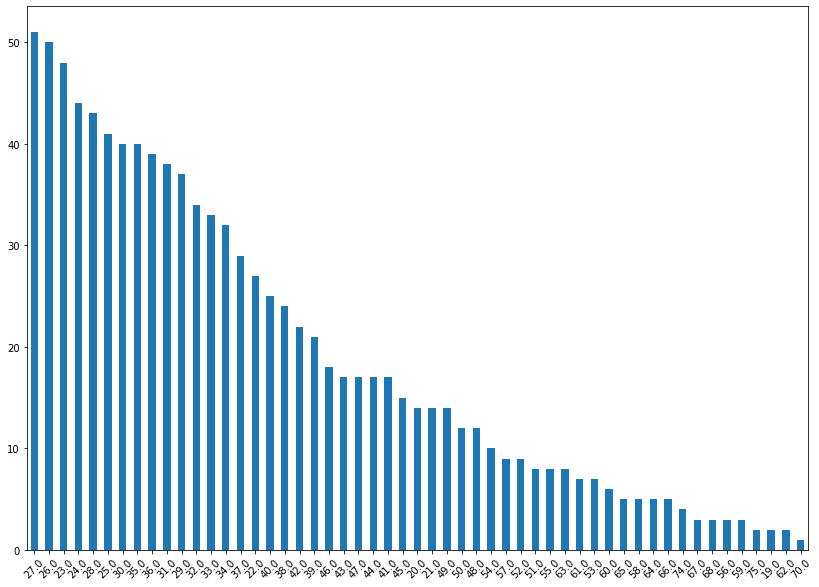

In [7]:
fig, ax = plt.subplots(figsize=(14, 10))
df["age"].value_counts().plot(kind='bar', rot=45)
ax.plot()

aggregate age in 3 groups --> problem of aggregation

In [8]:
df.loc[df['age'] >= 50, 'age_group'] = 2
df.loc[(df['age'] >= 30) & (df['age'] < 50), 'age_group'] = 1
df.loc[df['age'] < 30, 'age_group'] = 0
df['age_group'].value_counts(normalize=True) 

1.0    0.504
0.0    0.371
2.0    0.125
Name: age_group, dtype: float64

## (Group) Fairness Metrics

In [9]:
import warnings
def metrics_by_group(y, y_proba, A, thr=.5, pos_label=1):
    """
    computes performance metrics and plots the ROC by group 
    of a specific attribute of a binary classifier

    :param y: array or pd.Series with true labels
    :param y_proba: array or pd.Series with score outcome for the positive class
      of a binary classifier
    :param A: pd.Series with group membership
    :param thr: threshold used to compute the threshold-specific metric
    :param pos_label: the label of the positive class

    :return: 
      pd.DataFrame with metrics
      plot of the ROC by group
    """


    fig, ax = plt.subplots()  # prepare the figure for plotting
    df = []  # df that will contain the output

    # checks to be sure that A is given as a pd.Series
    if isinstance(A, pd.DataFrame):
      warnings.warn("A is a dataframe, we take the first column only")
      A = A.iloc[:, 0]
    
    if not isinstance(A, pd.Series):
      A = pd.Series(A)

    # loop over unique values of the sensitive attribute A
    for i in set(A):
        idx = A == i
        score_i = y_proba[idx]
        pred_i = 1*(score_i >= thr)
        y_i = y[idx]

        fpr, tpr, _ = roc_curve(y_i, score_i)
        df_i = pd.DataFrame(
            {"acc": accuracy_score(y_i, pred_i),
             "prec": precision_score(y_i, pred_i, pos_label=pos_label),
             "rec": recall_score(y_i, pred_i, pos_label=pos_label),
             "F1": f1_score(y_i, pred_i, pos_label=pos_label),
             "AUC": roc_auc_score(y_i, score_i),
             "ppr": sum(pred_i == pos_label) / len(pred_i)
             },
            index=[i]
        )
        if bool(A.name):
          df_i.index.name = A.name
        df.append(df_i)

        ax.plot(fpr, tpr, label=i)
        ax.set_xlabel("false positive rate")
        ax.set_ylabel("true positive rate")
        ax.legend()

    return pd.concat(df)

try with a random classifier

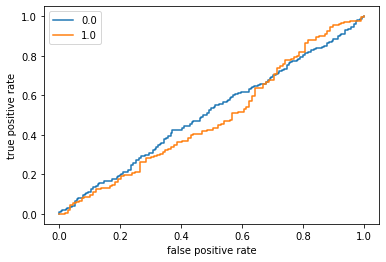

In [12]:
y_rand = np.random.uniform(0, 1, size=df.shape[0])
df_metrics = metrics_by_group(y=df.classification, y_proba=y_rand, A=df.gender)

In [13]:
print(df_metrics)

             acc      prec       rec        F1       AUC       ppr
gender                                                            
0.0     0.520290  0.734637  0.527054  0.613769  0.506815  0.518841
1.0     0.454839  0.606667  0.452736  0.518519  0.483546  0.483871


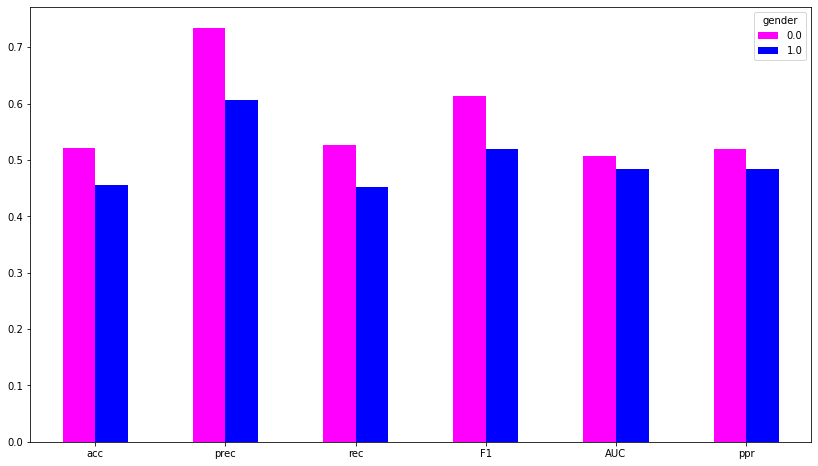

In [15]:
df_metrics.T.plot.bar(color={1: 'blue', 0: "magenta"}, rot=0, figsize=(14, 8))

inspect acceptance rate on orignal data

build functions of target (y) and prediction (yhat) 
it seems redundant, but will be useful later on

we define **positive prediction rate** as $ P(\hat{Y} = 1)$ and the **base rate** as $P(Y = 1)$

In [10]:
# positive prediction rate P(Yhat = 1)
def ppr(y, yhat, pos_label=1):
  return np.sum(yhat == pos_label) / len(yhat)
# base rate P(Y = 1)
def br(y, yhat, pos_label=1):
  return np.sum(y == pos_label) / len(y)

In [17]:
# these 2 will give the same output, i.e the base rate
print(ppr(None, df.classification))
print(br(df.classification, None))

0.7
0.7


In [19]:
# compute base rate by group
df.groupby('gender')['classification'].apply(lambda x: ppr(None, x))

gender
0.0    0.723188
1.0    0.648387
Name: classification, dtype: float64

In [ ]:
# notice that we have simply done the following
ppr_1 = np.sum(df.classification[df.gender == 1] == 1) / np.sum(df.gender == 1)
ppr_0 = np.sum(df.classification[df.gender == 0] == 1) / np.sum(df.gender == 0)
print(f"acceptance rate for 1: {ppr_1: .2},\nacceptance rate for 0 {ppr_0: .2}")

acceptance rate for 1:  0.65,
acceptance rate for 0  0.72


now we compute the **Demographic Parity difference** $$ \lvert P(\hat{Y} = 1\ \rvert\ A=1) - P(\hat{Y} = 1\ \rvert\ A=0)\rvert $$
and **Demographic Parity ratio** as $$ \frac{\min_a(P(\hat{Y} = 1\ \rvert\ A=a))}{\max_a(P(\hat{Y} = 1\ \rvert\ A=a))} \qquad(\leq 1)$$

In [ ]:
print(f"DP difference = {np.abs(ppr_1 - ppr_0): .3}")
print(f"DP ratio = {min(ppr_1, ppr_0) / max(ppr_1, ppr_0): .3}")

DP difference =  0.0748
DP ratio =  0.897


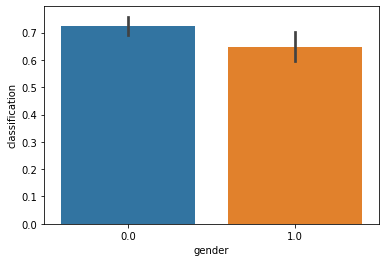

In [ ]:
# same thing but with a sns plot for gender
sns.barplot(x="gender", y="classification", data=df, ci=95)

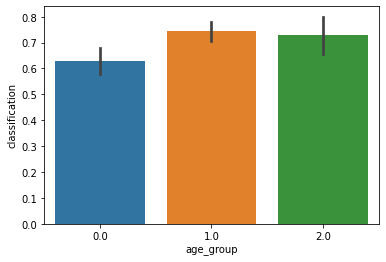

In [ ]:
# and for age groups
sns.barplot(x="age_group", y="classification", data=df, ci=95)

### Now with a model

In [11]:
target_variable = "classification"
sensitive = "age_group"

train test random split

In [12]:
X, Y, A = df.drop([target_variable, sensitive], axis=1), df.loc[:, target_variable], df.loc[:, sensitive]

In [13]:
random_seed = 42
np.random.seed(random_seed)

train/test splitting

In [14]:
X_train, X_test, Y_train, Y_test, A_train, A_test, df_train, df_test = train_test_split(
    X,
    Y,
    A,
    df,
    test_size=0.50,
    stratify=Y,
    random_state=random_seed
)

fit a model to the data

In [15]:
unmitigated_pipeline = Pipeline(steps=[
    ("preprocessing", StandardScaler()),
    ("logistic_regression", LogisticRegression(max_iter=1000)),
    #("random_forest", RandomForestClassifier(min_samples_split=30))
])

unmitigated_pipeline.fit(X_train, Y_train)

Pipeline(steps=[('preprocessing', StandardScaler()),
                ('logistic_regression', LogisticRegression(max_iter=1000))])

compute prediction on test set and check performance

In [16]:
y_proba = unmitigated_pipeline.predict_proba(X_test)[:,1]
y_pred = unmitigated_pipeline.predict(X_test)

In [17]:
# Show balanced accuracy rate of the 0/1 predictions
balanced_accuracy_score(Y_test, y_pred)

0.6942857142857143

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


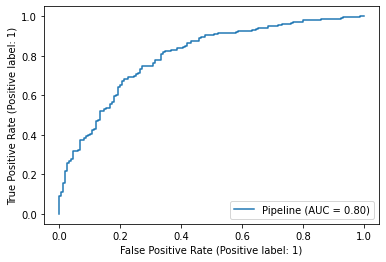

In [18]:
# Plot ROC curve of probabilistic predictions
plot_roc_curve(unmitigated_pipeline, X_test, Y_test)

let's also inspect performance on training set

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


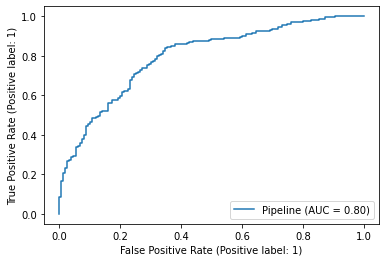

In [19]:
plot_roc_curve(unmitigated_pipeline, X_train, Y_train)

inspect metrics by groups of the sensitive attributes

                acc      prec       rec        F1       AUC       ppr
age_group                                                            
0.0        0.745763  0.783333  0.831858  0.806867  0.795769  0.677966
1.0        0.789062  0.807175  0.942408  0.869565  0.778494  0.871094
2.0        0.835821  0.830189  0.956522  0.888889  0.824017  0.791045


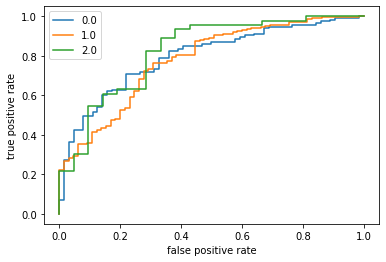

In [20]:
m_by_g = metrics_by_group(Y_test, y_proba, df_test[sensitive])
print(m_by_g)

Let's get the true positive rate ratio, namely the recall ratio. It is the ratio of the lowest recall with respect to the highest one, namely

In [21]:
tpr_ratio = m_by_g['rec'].min() / m_by_g['rec'].max()
print(f"true positive rate (a.k.a. recall) ratio: {tpr_ratio: .3}")

true positive rate (a.k.a. recall) ratio:  0.87


on gender would be

,acc,prec,rec,F1,AUC,ppr
gender,,,,,,
0.0,0.777465,0.802721,0.918288,0.856624,0.792663,0.828169
1.0,0.786207,0.803922,0.881720,0.841026,0.806038,0.703448


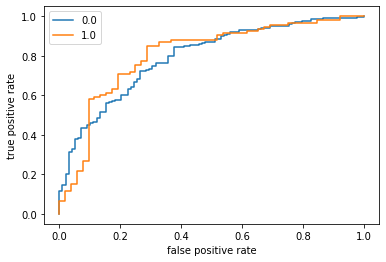

In [22]:
metrics_by_group(Y_test, y_proba, df_test.gender)

             acc      prec       rec        F1       AUC       ppr
gender                                                            
0.0     0.777465  0.802721  0.918288  0.856624  0.792663  0.828169
1.0     0.786207  0.803922  0.881720  0.841026  0.806038  0.703448
true positive rate (a.k.a. recall) ratio:  0.96


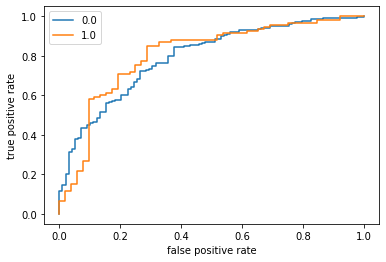

In [24]:
m_by_g = metrics_by_group(Y_test, y_proba, df_test['gender'])
print(m_by_g)
tpr_ratio = m_by_g['rec'].min() / m_by_g['rec'].max()
print(f"true positive rate (a.k.a. recall) ratio: {tpr_ratio: .3}")

### Fairlearn package

we can leverage several packages that help us in 2 aspects:
* assessing fairness, via predefined fairness metrics functions and utils,
* build mitigation strategies.

We shall here employ [Fairlearn](https://fairlearn.org/) but there are other packages (notably [IBM AIF360](https://aif360.mybluemix.net/), containing the adversarial debiasing algorithm).

In [25]:
# install fairlearn package
!pip install fairlearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
# fairlearn imports
# metrics
from fairlearn.metrics import (
    MetricFrame,
    true_positive_rate,
    false_positive_rate,
    false_negative_rate,
    selection_rate,
    count,
    false_negative_rate_difference
)

# mitigation
from fairlearn.postprocessing import ThresholdOptimizer, plot_threshold_optimizer

### use of fairlearn `MetricFrame` to assess fairness

In [27]:
# In its simplest form MetricFrame takes four arguments:
#    metric_function with signature metric_function(y_true, y_pred)
#    y_true: array of labels
#    y_pred: array of predictions
#    sensitive_features: array of sensitive feature values

mf1 = MetricFrame(metrics=false_negative_rate,
                  y_true=Y_test,
                  y_pred=y_pred,
                  sensitive_features=df_test['gender'])

# The disaggregated metrics are stored in a pandas Series mf1.by_group:

mf1.by_group

gender
0.0    0.081712
1.0     0.11828
Name: false_negative_rate, dtype: object

You can evaluate multiple metrics by providing a dictionary. The metrics that you can inspect need not to be native fairlearn function, you can use any function taking (y, yhat), such as sklearn metrics


In [28]:
metrics_dict = {
    "base_rate": br,
    "selection_rate": selection_rate,
    "positive_prediction_rate": ppr, #put here just for check, since it is equivalent to fairlearn selection rate
    "false_negative_rate": false_negative_rate,
    "false_positive_rate": false_positive_rate,
    "balanced_accuracy": balanced_accuracy_score,
    "recall": recall_score,
    "precision": precision_score,
    "f1": f1_score
}

metricframe_unmitigated = MetricFrame(metrics=metrics_dict,
                  y_true=Y_test,
                  y_pred=y_pred,
                  sensitive_features=df_test[sensitive])

# The disaggregated metrics are then stored in a pandas DataFrame:

metricframe_unmitigated.by_group

,base_rate,selection_rate,positive_prediction_rate,false_negative_rate,false_positive_rate,balanced_accuracy,recall,precision,f1
age_group,,,,,,,,,
0.0,0.638418,0.677966,0.677966,0.168142,0.40625,0.712804,0.831858,0.783333,0.806867
1.0,0.746094,0.871094,0.871094,0.057592,0.661538,0.640435,0.942408,0.807175,0.869565
2.0,0.686567,0.791045,0.791045,0.043478,0.428571,0.763975,0.956522,0.830189,0.888889


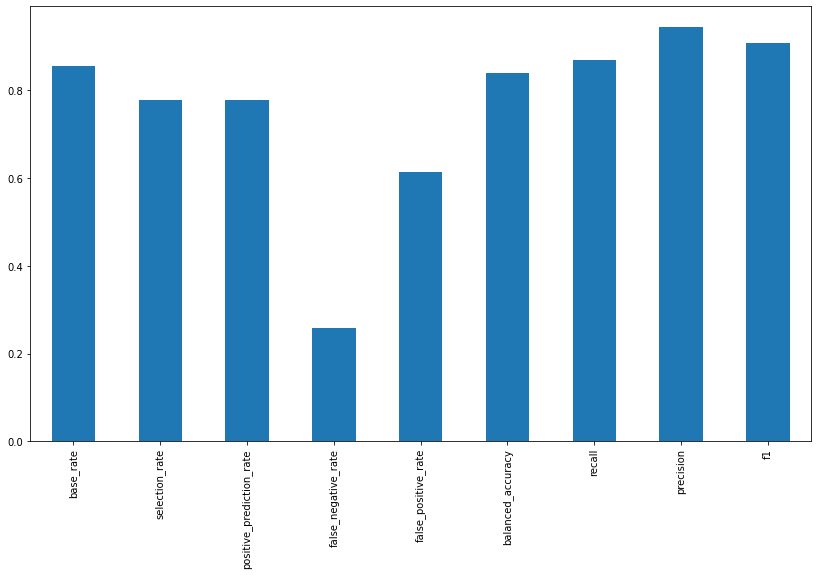

In [29]:
metricframe_unmitigated.ratio().plot.bar(figsize=(14, 8))

## Mitigation strategies

### postprocessing Threshold Optimizer

ThresholdOptimizer class is based on the work by [Hardt, Price & Srebro "Equality of Opportunity in supervised learning" NeurIPS (2016)](https://proceedings.neurips.cc/paper/2016/hash/9d2682367c3935defcb1f9e247a97c0d-Abstract.html).
The idea is simple: reach a desired parity by a smart choice of the thresholds on the score **by group**.

Possible constraints: *demographic_parity, (false/true)_(negative/positive)_rate_parity, equalized_odds*  

In [30]:
# Now we instantite ThresholdOptimizer with the fitted estimator
postprocess_est = ThresholdOptimizer(
    estimator=unmitigated_pipeline,
    constraints="false_negative_rate_parity",
    objective="balanced_accuracy_score",
    prefit=True, #  whether the given estimator is already fitted to data
    predict_method='predict_proba'
)

fit the postprocessing (in this case to the same training set)

In [31]:
postprocess_est.fit(X_train, Y_train, sensitive_features=A_train)

ThresholdOptimizer(constraints='false_negative_rate_parity',
                   estimator=Pipeline(steps=[('preprocessing',
                                              StandardScaler()),
                                             ('logistic_regression',
                                              LogisticRegression(max_iter=1000))]),
                   objective='balanced_accuracy_score',
                   predict_method='predict_proba', prefit=True)

compute mitigated prediction on test set and assess metrics

In [32]:
y_pred_postprocess = postprocess_est.predict(X_test, sensitive_features=A_test)

metricframe_postprocess = MetricFrame(
    metrics=metrics_dict,
    y_true=Y_test,
    y_pred=y_pred_postprocess,
    sensitive_features=A_test
)

show different out-of-sample metrics by group

In [33]:
pd.concat([metricframe_unmitigated.by_group,
           metricframe_postprocess.by_group],
          keys=['Unmitigated', 'Postprocessed'],
          axis=1)

Unmitigated                                          \
            base_rate selection_rate positive_prediction_rate   
age_group                                                       
0.0          0.638418       0.677966                 0.677966   
1.0          0.746094       0.871094                 0.871094   
2.0          0.686567       0.791045                 0.791045   

                                                                               \
          false_negative_rate false_positive_rate balanced_accuracy    recall   
age_group                                                                       
0.0                  0.168142             0.40625          0.712804  0.831858   
1.0                  0.057592            0.661538          0.640435  0.942408   
2.0                  0.043478            0.428571          0.763975  0.956522   

                              Postprocessed                 \
          precision        f1     base_rate selection_rate   
age_group                                                    
0.0        0.783333  0.806867      0.638418       0.570621   
1.0        0.807175  0.869565      0.746094       0.757812   
2.0        0.830189  0.888889      0.686567       0.686567   

                                                                            \
          positive_prediction_rate false_negative_rate false_positive_rate   
age_group                                                                    
0.0                       0.570621            0.283186              0.3125   
1.0                       0.757812            0.141361            0.461538   
2.0                       0.686567            0.130435            0.285714   

                                                           
          balanced_accuracy    recall precision        f1  
age_group                                                  
0.0                0.702157  0.716814   0.80198  0.757009  
1.0                 0.69855  0.858639  0.845361  0.851948  
2.0                0.791925  0.869565  0.869565  0.869565

compute out-of-sample ratios and plot them

In [34]:
df_metrics = pd.concat([metricframe_unmitigated.ratio(),
                        metricframe_postprocess.ratio()],
                       keys=['Unmitigated', 'Postprocessed'],
                       axis=1)

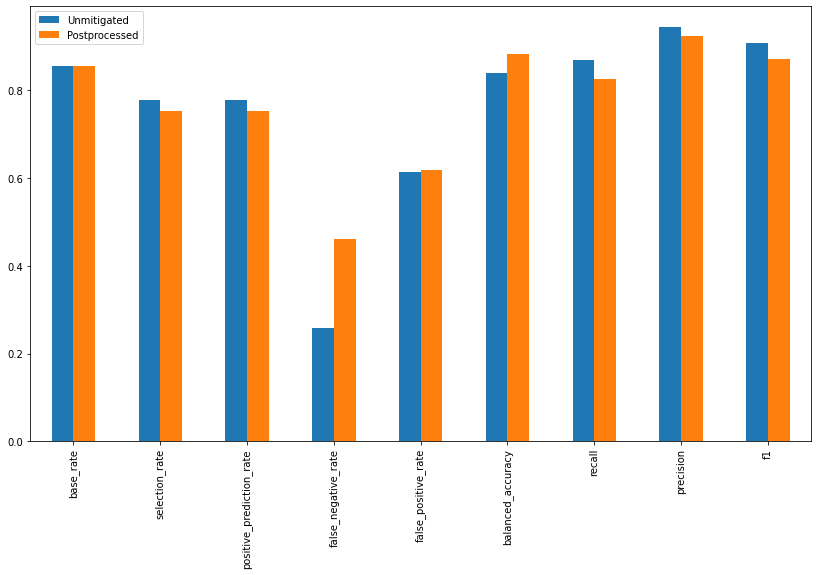

In [35]:
df_metrics.plot.bar(figsize=(14, 8))

Let's check also in-sample, i.e. on training data

In [36]:
y_pred_postprocess_training = postprocess_est.predict(X_train, sensitive_features=A_train)
metricframe_postprocess_training = MetricFrame(
    metrics=metrics_dict,
    y_true=Y_train,
    y_pred=y_pred_postprocess_training,
    sensitive_features=A_train
)
metricframe_postprocess_training.by_group

,base_rate,selection_rate,positive_prediction_rate,false_negative_rate,false_positive_rate,balanced_accuracy,recall,precision,f1
age_group,,,,,,,,,
0.0,0.623711,0.613402,0.613402,0.198347,0.30137,0.750142,0.801653,0.815126,0.808333
1.0,0.741935,0.681452,0.681452,0.201087,0.34375,0.727582,0.798913,0.869822,0.832861
2.0,0.775862,0.655172,0.655172,0.222222,0.230769,0.773504,0.777778,0.921053,0.843373


In [37]:
# Evaluate the difference between the largest and smallest value of each metric
metricframe_postprocess_training.ratio()

base_rate                   0.803895
selection_rate               0.90014
positive_prediction_rate     0.90014
false_negative_rate         0.892562
false_positive_rate         0.671329
balanced_accuracy            0.94063
recall                      0.970218
precision                   0.884994
f1                          0.958452
dtype: object

let's see the ROC on *train*

,acc,prec,rec,F1,AUC,ppr
age_group,,,,,,
0.0,0.711340,0.737226,0.834711,0.782946,0.748443,0.706186
1.0,0.778226,0.808612,0.918478,0.860051,0.810887,0.842742
2.0,0.810345,0.854167,0.911111,0.881720,0.830769,0.827586


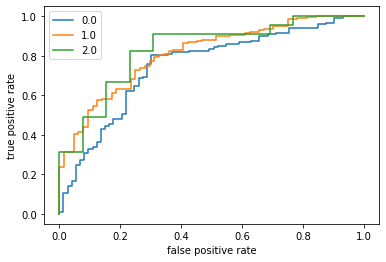

In [38]:
metrics_by_group(Y_train, unmitigated_pipeline.predict_proba(X_train)[:, 1], df_train[sensitive])